# Approach 2

In this notebook we explore and evaluate using an instruction tuned model to detect defective lines of code.

In [24]:
from datasets import load_dataset
import numpy as np
import subprocess
import difflib
import autopep8
import requests as req
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import json
import tree_sitter_python as tspython
import tree_sitter_java as tsjava

from tree_sitter import Language, Parser
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

## Datset loading and preprocessing

We only use logic errors and perform the following preprocessing steps:
- Remove examples containing syntax errors
- Remove blank lines
- Format the buggy code and the solution
- Remove comments

In [7]:
dataset = load_dataset("Rtian/DebugBench")
df = pd.DataFrame(dataset['test'])
filtered_df = df[df['category'] == 'logic error'].copy()

In [ ]:
PY_LANGUAGE = Language(tspython.language(), "python")
JAVA_LANGUAGE = Language(tsjava.language(), "java")

py_parser = Parser()
py_parser.set_language(PY_LANGUAGE)

java_parser = Parser()
java_parser.set_language(JAVA_LANGUAGE)

def remove_blank_lines(text):
    return "\n".join([s.rstrip() for s in text.splitlines() if s.strip()])
    
def format_cpp_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format.txt'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        if process.returncode != 0:
            print("Error cpp formatting code: ", errors.decode())
            return code
        process = subprocess.Popen(['g++', '-fpreprocessed', '-dD', '-E', '-P', '-'],
                                   stdin=subprocess.PIPE,
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=formatted_code)

        
        if process.returncode != 0:
            print("Error cpp formatting code: ", errors.decode())
            return code
        
        return remove_blank_lines(formatted_code.decode())
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    
def format_python_code(code):
    try:
        # ignore errors to prevent autopep from running forever
        formatted_code = autopep8.fix_code(code, options={'ignore': ['E']})
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    bytes_code = bytes(formatted_code, "utf-8")
    array = bytearray(bytes_code)
    tree = py_parser.parse(bytes_code)
    def traverse(node):
        if node.type == 'comment':
            array[node.start_byte:node.end_byte]=(node.end_byte - node.start_byte) * b" "
            return 
        elif node.child_count == 0:
            return
        else:
            for child in node.children:
                traverse(child)
            return
    traverse(tree.root_node)
    cleaned_code = array.decode("utf-8")
    return remove_blank_lines(cleaned_code)


def format_java_code(code):
    try:
        process = subprocess.Popen(['clang-format', '--style=file:./clang-format-java.txt', '--assume-filename=Main.java'], 
                                   stdin=subprocess.PIPE, 
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.PIPE)
        formatted_code, errors = process.communicate(input=code.encode())
        
        if process.returncode != 0:
            print("Error formatting java code: ", errors.decode())
            return code
        
    except Exception as e:
        print(f"An exception occurred: {e}")
        return code
    
    array = bytearray(formatted_code)
    tree = java_parser.parse(formatted_code)
    def traverse(node):
        if "comment" in node.type:
            #print(f"Removed comment: {array[node.start_byte:node.end_byte].decode('utf-8')}")
            array[node.start_byte:node.end_byte]=(node.end_byte - node.start_byte) * b" "
            return 
        elif node.child_count == 0:
            return
        else:
            for child in node.children:
                traverse(child)
            return
    
    traverse(tree.root_node)
    cleaned_code = array.decode("utf-8")
    return remove_blank_lines(cleaned_code)

def format_code(code, language):
    if language == "python3":
        return format_python_code(code)
    elif language == "cpp":
        return format_cpp_code(code)
    elif language == "java":
        return format_java_code(code)
    else:
        print(f"Unsupported language: {language}")
        return code

def format_entry(entry):
    buggy_code = entry['buggy_code']
    solution = entry['solution']
    return pd.Series({
        "buggy_code_formatted": format_code(buggy_code, entry['language']),
        "solution_formatted": format_code(solution, entry['language'])
    })
    
filtered_df[["buggy_code_formatted", "solution_formatted"]] = filtered_df.progress_apply(format_entry, axis=1)

formatted_df = filtered_df
formatted_df.to_csv("./notebooks/results/formatted_code.csv", index=False)

## Prompt the LLM
After the preprocessing, we now retrieve lines of code that are relevant for fixing the code.

In [8]:
formatted_df = pd.read_csv("./notebooks/results/formatted_code.csv")


formatted_df['buggy_code'] = formatted_df['buggy_code'].apply(str)
formatted_df['buggy_code_formatted'] = formatted_df['buggy_code_formatted'].apply(str)

formatted_df['solution'] = formatted_df['solution'].apply(str)
formatted_df['solution_formatted'] = formatted_df['solution_formatted'].apply(str)

In [11]:
def find_changed_lines(file1_contents, file2_contents, print_diff=False):
    diff = difflib.ndiff(file1_contents.splitlines(), file2_contents.splitlines())
    
    changed_lines = set() # change or insert below

    current_line_number = 0
    pending_change = False
    for line in diff: 
        if print_diff:
            print(f"{current_line_number}: {line}")
 
        if line.startswith('  '):
            current_line_number += 1
            pending_change = False
        else:
            if line.startswith('- '):  # Lines in file1 but not in file2
                pending_change = True
                current_line_number += 1
                changed_lines.add(current_line_number)
            elif line.startswith('+ '):  # Lines in file2 but not in file1
                if pending_change:
                    pending_change = False
                else:
                    changed_lines.add(current_line_number)
    return list(changed_lines)

In [ ]:
log_file_name = "output_with_context.json"
results_file_name = "results_context.csv"

log_file = open(log_file_name, "w")
log_file.write("[")

def retrieve_relevant_lines_for_entry(entry):
    buggy_code = entry['buggy_code_formatted']
    solution = entry['solution_formatted']
    num_lines = buggy_code.count('\n')
    changed_lines = find_changed_lines(buggy_code, solution)

    data = {"code": buggy_code, "language": entry['language'], "context": entry["question"]}
    success = True
    response_json = []
    try:
        resp = req.post("http://delos.eaalab.hpi.uni-potsdam.de:8010/highlight-code/", json=data)
        try:
            response_json = resp.json()
        except:
            print("Json parsing failed")
            print(resp.text())
    except:
        print("Request failed")
        success = False    

    predicted_lines = []
    suggestions = []
    descriptions = []
    actions = []
    for item in response_json:
        line_number = int(item.get('line_number', "1"))
        suggestions.append(item.get("description", ""))
        descriptions.append(item.get("suggestion", ""))
        predicted_lines.append(line_number)
        actions.append(item.get("action", ""))

    result = {
        'buggy_code': buggy_code,
        'solution': solution,
        'changed_lines': changed_lines,
        'predicted_lines': predicted_lines,
        'num_lines': num_lines,
        'success': success,
        'suggestions': suggestions,
        'descriptions': descriptions,
        'actions': actions,
    }
    log_file.write(f'{json.dumps(result)},')
    log_file.flush()
    return result


results = formatted_df.progress_apply(retrieve_relevant_lines_for_entry, axis=1)

log_file.write("]")
log_file.close()
results_df = pd.DataFrame(results.tolist())
results_df.to_csv(results_file_name, index=False)

In [50]:
skip = True
if not skip:
    import ast
    df = pd.read_csv("./notebooks/results/results_context_complete.csv")
    #df['num_clusters'] = df['changed_lines'].apply(ast.literal_eval[1])
    df['changed_lines'] = df['changed_lines'].apply(ast.literal_eval)
    df['predicted_lines'] = df['predicted_lines'].apply(ast.literal_eval)
    df['actions'] = df['actions'].apply(ast.literal_eval)
    # tell pythont hat buggy_code is a string
    df['buggy_code'] = df['buggy_code'].apply(str)
    df['solution'] = df['solution'].apply(str)
else:
    df = results_df.copy()


In [51]:
## remove changed lines and num_clusters from the results
df = df.drop(columns=['changed_lines'])
## recompute changed lines
df['changed_lines'] = df.apply(lambda x: find_changed_lines(x['buggy_code'], x['solution']), axis=1)
#df.to_csv("results_formatted.csv", index=False)

In [52]:
# Use values to ignore underlying indexes
df['language'] = filtered_df['language'].values
df['level'] = filtered_df['level'].values
df['category'] = filtered_df['category'].values


In [53]:
success_df = df[df["success"]]
print(f'Number of successful requests: {len(success_df)}')
print(f'Number of unsuccessful requests: {len(df) - len(success_df)}')
print(df.iloc[0])

Number of successful requests: 590
Number of unsuccessful requests: 0
buggy_code         class Solution {\n   public:\n    long long fa...
solution           class Solution {\n   public:\n    long long fa...
predicted_lines                                                   []
num_lines                                                         24
success                                                         True
suggestions                                                       []
descriptions                                                      []
actions                                                           []
changed_lines                                                    [5]
language                                                         cpp
level                                                           easy
category                                                 logic error
Name: 0, dtype: object


In [54]:
eval_df = df.copy()

In [55]:
eval_df.head()

,buggy_code,solution,predicted_lines,num_lines,success,suggestions,descriptions,actions,changed_lines,language,level,category
0,class Solution {\n public:\n long long fa...,class Solution {\n public:\n long long fa...,[],24,True,[],[],[],[5],cpp,easy,logic error
1,class Solution {\n public:\n TreeNode* me...,class Solution {\n public:\n TreeNode* me...,"[6, 10]",12,True,['The left child of the merged node should be ...,"['Change t2->right to t2->left.', 'Change the ...","[change, change]","[6, 7]",cpp,easy,logic error
2,class Solution {\n public:\n int halveArr...,class Solution {\n public:\n int halveArr...,[18],21,True,['The line incorrectly adds the doubled value ...,['Change the operator to -=.'],[change],[18],cpp,medium,logic error
3,class Solution {\n public:\n int maximize...,class Solution {\n public:\n int maximize...,"[7, 8, 23]",26,True,"['The target value is not used in the code.', ...",['Remove the line as it is not necessary for t...,"[delete, delete, delete]",[23],cpp,medium,logic error
4,class Solution {\n public:\n int ans = 0;...,class Solution {\n public:\n int ans = 0;...,"[7, 11]",12,True,['The loop iterates over a copy of the dp vect...,['Use a range-based for loop to iterate over t...,"[change, change]",[8],cpp,medium,logic error


In [56]:
def create_labels(row):
    labels = pd.Series([0] * (row['num_lines'] + 1)) # Why +1? 
    for line in row['changed_lines']:
        if line > row['num_lines'] +1:
            print(f"Error {line} exceeds {row['num_lines']}")
            continue
        if line == 0: # Special case in which an insertion before the first line is required.
            labels[0] = 1
        else: 
            labels[line-1] = 1 # lines are 1-indexed so we subtract 1
    assert len(labels) == row['num_lines']+1, f"{len(labels)} != {row['num_lines']}"
    return labels.tolist()

def create_predictions(row):
    predictions = pd.Series([0] * (row['num_lines'] + 1))
    for i, line in enumerate(row['predicted_lines']):
        action = row['actions'][i]
        relevant_line = line
        if action == "insert_below":
            pass
        elif action == "insert_above":
            relevant_line -= 1
        elif action == "change" or action == "delete" or action == "remove" or action == "modify":
            pass
        else:
            print(f"Unknown action: {action}")
            continue

        if relevant_line > row['num_lines'] + 1:
            print(f"Error {line} exceeds {row['num_lines']}")
            continue
        predictions[relevant_line-1] = 1
    assert len(predictions) == row['num_lines'] +1, f"{len(labels)} != {row['num_lines']}"
    return predictions.tolist()

eval_df['labels'] = eval_df.apply(create_labels, axis=1)
eval_df['predictions'] = eval_df.apply(create_predictions, axis=1)

labels = np.array([b for a in eval_df['labels'].values for b in a])
predictions = np.array([b for a in eval_df['predictions'].values for b in a])
assert len(labels) == len(predictions)

Unknown action: add_comment
Unknown action: add_comment
Unknown action: add_comment
Unknown action: move
Unknown action: add_loop
Unknown action: move
Unknown action: add_check
Unknown action: review
Unknown action: review
Unknown action: add
Unknown action: add_helper_function
Unknown action: change_algorithm
Unknown action: modify_logic
Unknown action: add_bounds_check
Unknown action: move_inside_loop
Unknown action: move_below_if
Unknown action: review
Unknown action: add
Unknown action: add
Unknown action: add
Unknown action: add
Unknown action: add
Unknown action: modify data structure
Unknown action: move
Unknown action: move
Unknown action: no_change
Unknown action: keep
Unknown action: replace
Unknown action: replace
Unknown action: add
Unknown action: indent
Unknown action: replace
Unknown action: move
Unknown action: move
Unknown action: add_else_block
Unknown action: add_sort_to_res
Unknown action: no_action
Unknown action: no_action
Unknown action: comment
Unknown action: m

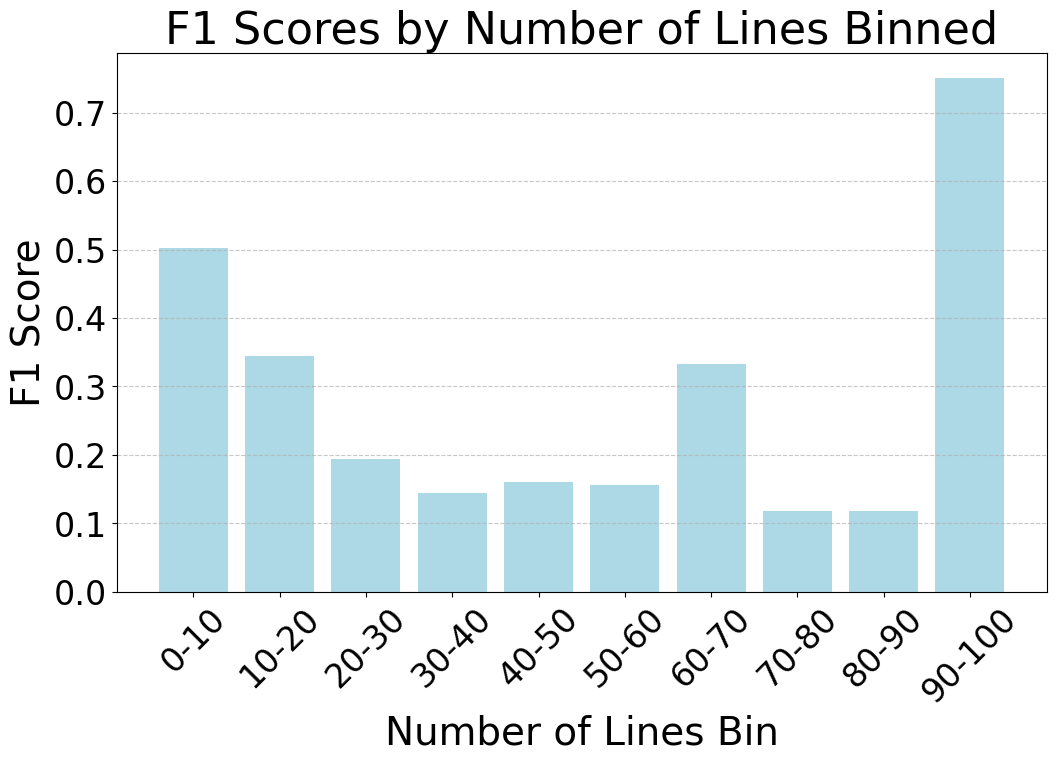

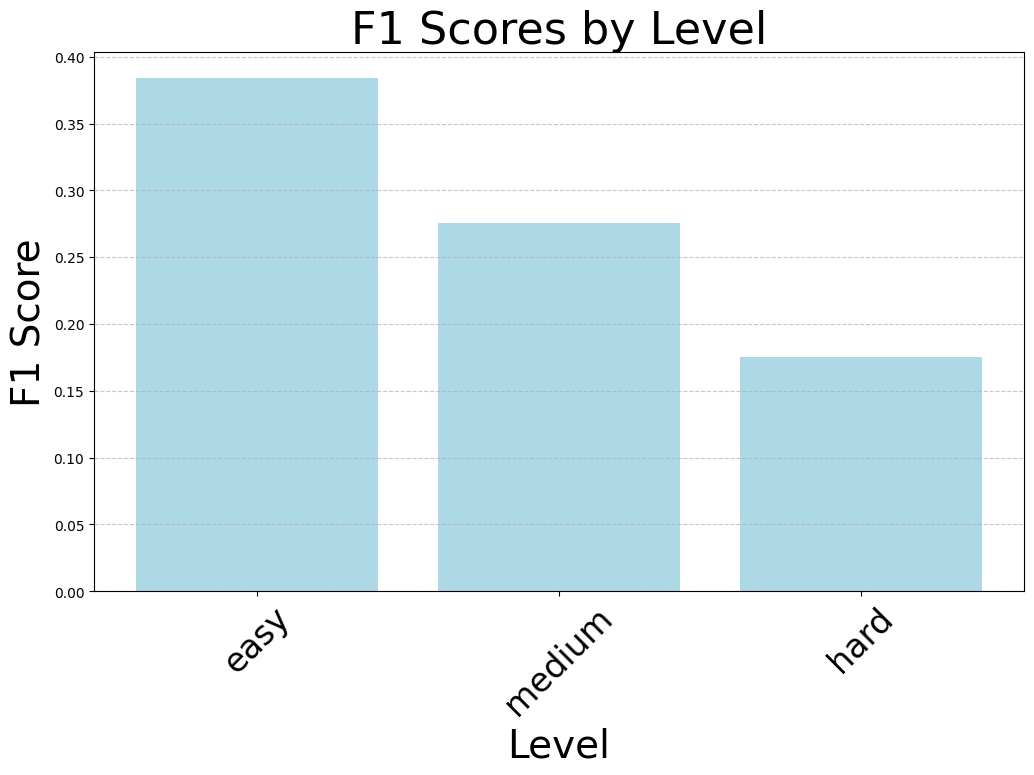

In [57]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = [f'{b}-{b+10}' for b in bins[:-1]]

eval_df['num_lines_bin'] = pd.cut(eval_df['num_lines'], bins=bins, labels=bin_labels, right=False)

def calculate_bin_f1(group):
    labels = np.array([b for a in group['labels'].values for b in a])
    predictions = np.array([b for a in group['predictions'].values for b in a])
    if len(labels) == 0:
        return np.nan
    return f1_score(labels, predictions)

grouped = eval_df.groupby('num_lines_bin').apply(calculate_bin_f1).reset_index(name='f1_score')
grouped2 = eval_df.groupby('level').apply(calculate_bin_f1).reset_index(name='f1_score')
plt.figure(figsize=(12, 7))
plt.bar(grouped['num_lines_bin'].astype(str), grouped['f1_score'], color='lightblue')
plt.title('F1 Scores by Number of Lines Binned', fontsize=32)
plt.xlabel('Number of Lines Bin', fontsize=28)
plt.ylabel('F1 Score', fontsize=28)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(12, 7))
# order to easy, medium, hard so it is plotted in that order
level_order = ['easy', 'medium', 'hard']
grouped2_ordered = grouped2.set_index('level').reindex(level_order).reset_index()

plt.bar(grouped2_ordered['level'].astype(str), grouped2_ordered['f1_score'], color='lightblue')
plt.title('F1 Scores by Level', fontsize=32)
plt.xlabel('Level', fontsize=28)
plt.ylabel('F1 Score', fontsize=28)
plt.xticks(rotation=45, fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [58]:

def entry_based_metrics(entry):
    labels = np.array(entry['labels'])
    predictions = np.array(entry['predictions'])
    conf_matrix = confusion_matrix(labels, predictions, labels=[0, 1])

    return {'tn': conf_matrix[0][0],
            'fn': conf_matrix[1][0],
            'fp': conf_matrix[0][1],
            'tp': conf_matrix[1][1],
            'f1': f1_score(labels, predictions)}



results = eval_df.progress_apply(entry_based_metrics, axis=1)

results_df = pd.DataFrame(results.tolist())

eval_df['tp'] = results_df['tp']
eval_df['fp'] = results_df['fp']
eval_df['fn'] = results_df['fn']
eval_df['tn'] = results_df['tn']
eval_df['f1'] = results_df['f1']


  0%|          | 0/590 [00:00<?, ?it/s]

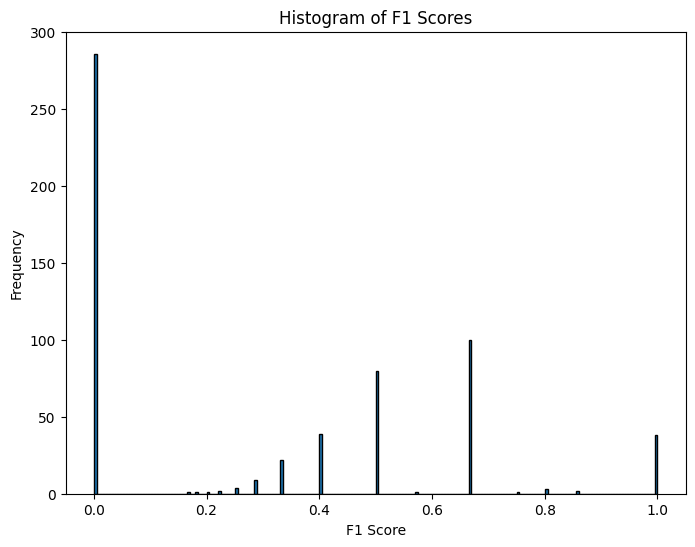

In [59]:
plt.figure(figsize=(8, 6))
plt.hist(eval_df['f1'], bins=200, edgecolor='black')
plt.title('Histogram of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()

In [60]:
from IPython.display import display, HTML
res_df = eval_df.sort_values(by='f1', ascending=False).head(2)#[['buggy_code', 'solution', 'changed_lines', 'predicted_lines']]

def pretty_print(input_df):
    return display(HTML(input_df.to_html().replace("\\n", "<br>")))

pretty_print(res_df)

,buggy_code,solution,predicted_lines,num_lines,success,suggestions,descriptions,actions,changed_lines,language,level,category,labels,predictions,num_lines_bin,tp,fp,fn,tn,f1
428,"class Solution: def makeSubKSumEqual(self, A: List[int], K: int) -> int: lA = len(A) g = gcd(lA, K) retV = 0 for i in range(g): med = int(median(A[i:g])) retV += sum(abs(a-med) for a in A[i:g]) return retV","class Solution: def makeSubKSumEqual(self, A: List[int], K: int) -> int: lA = len(A) g = gcd(lA, K) retV = 0 for i in range(g): med = int(median(A[i::g])) retV += sum(abs(a-med) for a in A[i::g]) return retV","[7, 8]",8,True,"['The median function may not be available in all Python versions. Consider using the `statistics.median()` function instead.', 'The sum of absolute differences can be calculated more efficiently using the formula `sum(abs(a-med)) - g * med`, where g is the length of the subarray.']","['Replace `median()` with `statistics.median()`.', 'Replace the list comprehension with `retV += sum(abs(a-med)) - g * med`.']","[change, change]","[8, 7]",python3,medium,logic error,"[0, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 1, 0]",0-10,2,0,0,7,1.0
408,"class Solution: def canEat(self, candiesCount: List[int], queries: List[List[int]]) -> List[bool]: prefix = [0] for x in candiesCount: prefix.append(prefix[-1] + x) return [prefix[t-1] < (day+1)*cap and day < prefix[t+1] for t, day, cap in queries]","class Solution: def canEat(self, candiesCount: List[int], queries: List[List[int]]) -> List[bool]: prefix = [0] for x in candiesCount: prefix.append(prefix[-1] + x) return [prefix[t] < (day+1)*cap and day < prefix[t+1] for t, day, cap in queries]",[5],4,True,"[""The condition in the list comprehension is incorrect. It should be 'prefix[t] < (day+1)*cap and day < prefix[t+1]' to check the number of candies of type t available on or before day day.""]","[""Change the condition in the list comprehension to 'prefix[t] < (day+1)*cap and day < prefix[t+1]'.""]",[change],[5],python3,medium,logic error,"[0, 0, 0, 0, 1]","[0, 0, 0, 0, 1]",0-10,1,0,0,4,1.0


In [61]:
def aggregate_and_print(input_df):
    tn = input_df['tn'].sum()
    fn = input_df['fn'].sum()
    tp = input_df['tp'].sum()
    fp = input_df['fp'].sum()
    print([tn, fp], "\n",
           [fn, tp])

In [62]:
print("different levels")
easy_df = eval_df[eval_df['level'] == 'easy']
aggregate_and_print(easy_df)
mid_df = eval_df[eval_df['level'] == 'medium']
aggregate_and_print(mid_df)
hard_df = eval_df[eval_df['level'] == 'hard']
aggregate_and_print(hard_df)

print("non zero")
non_zero_df = eval_df[eval_df['suggestions'].apply(lambda x: len(x) > 0)]
aggregate_and_print(non_zero_df)

print("zero")
zero_df = eval_df[eval_df['suggestions'].apply(lambda x: len(x) == 0)]
aggregate_and_print(zero_df)

differen levels
[2607, 341] 
 [127, 146]
[4902, 566] 
 [212, 148]
[2970, 258] 
 [90, 37]
non zero
[10479, 1165] 
 [429, 331]
zero
[0, 0] 
 [0, 0]
error types
[0, 0] 
 [0, 0]
[0, 0] 
 [0, 0]
[10479, 1165] 
 [429, 331]
[0, 0] 
 [0, 0]


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score

accuracy = accuracy_score(labels, predictions)
balanced_acc = balanced_accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
conf_matrix = confusion_matrix(labels, predictions)


print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.8714930667526605
Balanced Accuracy: 0.6677373935525864
Precision: 0.2212566844919786
Recall: 0.4355263157894737
F1 Score: 0.29343971631205673
Confusion Matrix:
[10479  1165   429   331]
